# Imports

In [ ]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K 

# import metrics
import utils
# import loss
import keras.utils
import tensorflow as tf
import os
import skimage.transform
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dice Loss

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=1e-6):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    dice_numerator =2* K.sum(y_pred * y_true,axis=axis) + epsilon
    dice_denominator = (K.sum(y_pred,axis=axis) + K.sum(y_true,axis=axis)) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator)
    
    return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator =2* K.sum(y_pred * y_true,axis=axis) + epsilon
    dice_denominator = (K.sum(y_pred,axis=axis) + K.sum(y_true,axis=axis)) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)
    return dice_loss

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

In [ ]:
weights = tf.constant([1.01623644e+00, 2.83708569e+03, 7.07755237e+01, 6.68729348e+02])

In [ ]:
def weighted_loss(y_true, y_pred):
  ce = tf.keras.losses.SparseCategoricalCrossentropy()
  return ce(y_true, y_pred, sample_weight = weights)

# Standardize

In [ ]:
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # initialize to array of zeros, with same shape as the image
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - image_slice.mean()
            
            # divide by the standard deviation (only if it is different from zero)
            if image_slice.std()!=0:
                centered_scaled = centered/image_slice.std()

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] =centered_scaled
    ### END CODE HERE ###

    return standardized_image

# Trian and validation generator

In [ ]:
def generatorTrain(batch_size):
  while True:
    ids = list(range(1,205,1))
    X = np.zeros((batch_size, 4, 128, 128, 128))
    y = np.zeros((batch_size, 3, 128, 128, 128))
    # cnt = 1
    while len(ids) > 0:
      for i in range(batch_size):
        cnt = random.choice(ids)
        img = np.load(f'drive/MyDrive/data_pub/train/{cnt:03}_imgs.npy')
        seg = np.load(f'drive/MyDrive/data_pub/train/{cnt:03}_seg.npy')
        img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
        img = standardize(img)
        # img = np.moveaxis(img, 0,-1)
        seg = skimage.transform.resize(seg, (128, 128, 128), preserve_range=True).astype(int)
        seg = keras.utils.to_categorical(seg,4)
        seg = np.moveaxis(seg,-1,0)
        # pop from list
        ids.remove(cnt)
        # augment data by flipping
        # aug = random.choice([True, False])
        # if aug:
        #   axis = random.randint(1,3)
        #   img = np.flip(img, axis)
        #   seg = np.flip(seg, axis)
        X[i] = img
        y[i] = seg[1:]
      yield X, y

In [ ]:
def generatorVal(batch_size):
  while True:
    ids = list(range(1,69,1))
    X = np.zeros((batch_size, 4, 128, 128, 128))
    y = np.zeros((batch_size, 3, 128, 128, 128))
    # cnt = 1
    while len(ids) > 0:
      for i in range(batch_size):
        cnt = random.choice(ids)
        # print(f'loading case {cnt}')
        img = np.load(f'drive/MyDrive/data_pub/validation/{cnt:03}_imgs.npy')
        seg = np.load(f'drive/MyDrive/data_pub/validation/{cnt:03}_seg.npy')
        img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
        img = standardize(img)
        
        seg = skimage.transform.resize(seg, (128, 128, 128), preserve_range=True).astype(int)
        seg = keras.utils.to_categorical(seg,4)
        seg = np.moveaxis(seg,-1,0)
        # pop from list
        ids.remove(cnt)
        # augment data by flipping
        # aug = random.choice([True, False])
        # if aug:
        #   axis = random.randint(1,3)
        #   img = np.flip(img, axis)
        #   seg = np.flip(seg, axis)
        X[i] = img
        y[i] = seg[1:]
      yield X, y

In [ ]:
test_gen = generatorTrain(1)
for i in range(3):
  a,b = next(test_gen)
  print(np.max(a), np.min(a), np.max(b), np.min(b))

13.664973258972168 -72.50199890136719 1.0 0.0
54.941795349121094 -68.77861022949219 1.0 0.0
43.20978546142578 -48.95195007324219 1.0 0.0


# Load Model

In [70]:
model = utils.unet_model_3d(loss_function=dice_coefficient_loss, metrics=[dice_coefficient], input_shape=(4,128,128,128),
                            include_label_wise_dice_coefficients=True, initial_learning_rate = 1e-4)

In [71]:
if os.path.isdir("drive/MyDrive/testModel") is False:
  os.mkdir("drive/MyDrive/testModel")
checkpoint_path = "drive/MyDrive/testModel/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [72]:
train_generator = generatorTrain(1)
val_generator = generatorVal(1)

In [ ]:
model.fit_generator(generator=train_generator,
        steps_per_epoch=204,
        validation_data=val_generator,
        validation_steps=68,
        callbacks=[cp_callback],
        epochs=200)

In [75]:
model.load_weights("drive/MyDrive/3dunet_model/cp-0052.ckpt")

# Test Generator

In [76]:
dimensions = []

In [123]:
def generatorTest(batch_size=1):
  X = np.zeros((batch_size, 4, 128, 128, 128))
  cnt = 1
  while cnt < 69:
    for i in range(batch_size):
      img = np.load(f'drive/MyDrive/test_pub/{cnt:03}_imgs.npy')
      dimensions.append(img.shape)
      img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
      img = standardize(img)
      cnt += 1
      X[i] = img
    yield X

In [143]:
generator_test = generatorTest(1)

In [ ]:
# for i in range(68):
#   test = next(generator_test)

# Generate predictions

In [144]:
model = utils.unet_model_3d(loss_function=dice_coefficient_loss, metrics=[dice_coefficient], input_shape=(4,128,128,128),
                            include_label_wise_dice_coefficients=True, initial_learning_rate = 1e-4)

In [145]:
model.load_weights("drive/MyDrive/3dunet_model_latest/cp-0008.ckpt")

In [146]:
segs = model.predict(generator_test)

In [141]:
segs.shape

(68, 3, 128, 128, 128)

# Combine results

In [147]:
# set threshold.
def combine(result, threshold=0.5):
  p = np.zeros((4,128,128,128))
  for i in range(128):
    for j in range(128):
      for k in range(128):
        v = result[:,i,j,k]
        if np.max(v) <= threshold:
          p[0,i,j,k] = 1
        else:
          label = np.argmax(v) + 1
          p[label, i,j,k] = 1
  return p

In [148]:
for i in range(68):
  tmp = combine(segs[i])
  tmp = np.argmax(tmp, axis=0)
  tmp = skimage.transform.resize(tmp, dimensions[i][1:], preserve_range=True)
  np.save(f'drive/MyDrive/segs/{i+1:03}_seg.npy', tmp)
  print(f'prediction: {i} ----------------, {tmp.shape}')

prediction: 0 ----------------, (134, 177, 139)
prediction: 1 ----------------, (140, 173, 139)
prediction: 2 ----------------, (142, 164, 139)
prediction: 3 ----------------, (141, 173, 134)
prediction: 4 ----------------, (137, 163, 142)
prediction: 5 ----------------, (131, 167, 131)
prediction: 6 ----------------, (141, 177, 140)
prediction: 7 ----------------, (140, 168, 140)
prediction: 8 ----------------, (137, 176, 142)
prediction: 9 ----------------, (141, 165, 136)
prediction: 10 ----------------, (143, 173, 131)
prediction: 11 ----------------, (135, 162, 135)
prediction: 12 ----------------, (138, 164, 142)
prediction: 13 ----------------, (143, 176, 153)
prediction: 14 ----------------, (135, 164, 144)
prediction: 15 ----------------, (143, 168, 137)
prediction: 16 ----------------, (139, 176, 138)
prediction: 17 ----------------, (143, 187, 132)
prediction: 18 ----------------, (132, 166, 142)
prediction: 19 ----------------, (137, 174, 137)
prediction: 20 ---------------

In [149]:
test = np.load('drive/MyDrive/segs/010_seg.npy')

In [150]:
img = np.load('drive/MyDrive/test_pub/010_imgs.npy')

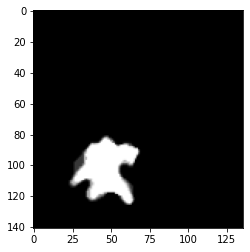

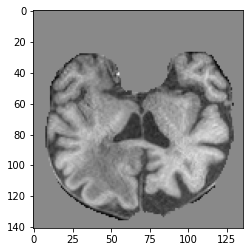

In [152]:
plt.imshow(test[:,60,:], cmap='gray')
plt.show()
plt.imshow(img[0,:,60,:], cmap='gray')
plt.show()

# Test

In [89]:
img = np.load('drive/MyDrive/data_pub/train/001_imgs.npy')
lbl = np.load('drive/MyDrive/data_pub/train/001_seg.npy')

In [ ]:
# unique, counts = np.unique(lbl, return_counts=True)
# unique, counts, np.sum(counts)
# weights = np.sum(counts) / counts
# weights

array([1.01623644e+00, 2.83708569e+03, 7.07755237e+01, 6.68729348e+02])

In [90]:
dim = img.shape[1:]
img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
img = standardize(img)
img_p = model.predict(np.array([img]))
lbl_p = combine(img_p[0])
lbl_p = np.argmax(lbl_p, axis=0)
lbl_p = skimage.transform.resize(lbl_p, dim, preserve_range=True)

In [105]:
np.min(img_p[0,0,:,:,:])

0.00061332254

In [91]:
np.max(img_p), lbl.shape, lbl_p.shape, dim

(0.99948835, (137, 169, 143), (137, 169, 143), (137, 169, 143))

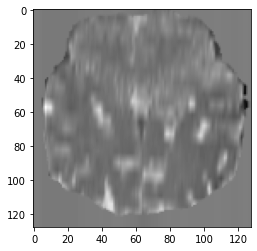

In [ ]:
plt.imshow(img[2,:,80,:], cmap='gray')

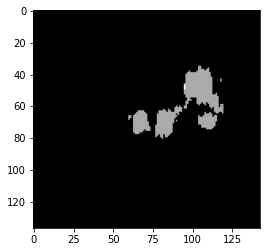

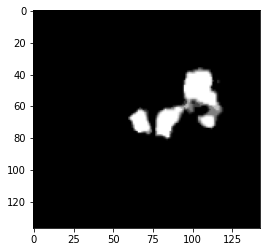

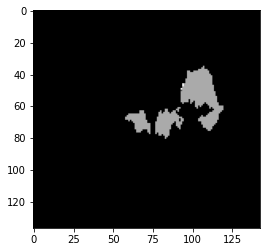

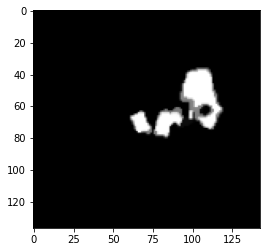

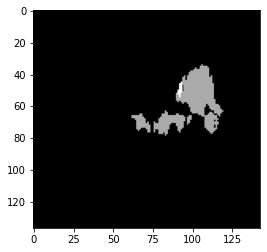

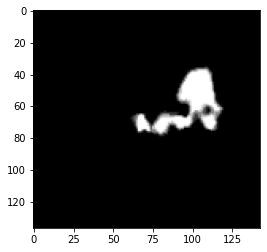

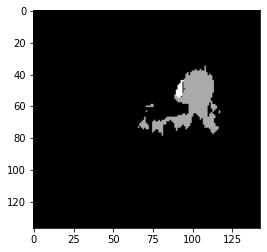

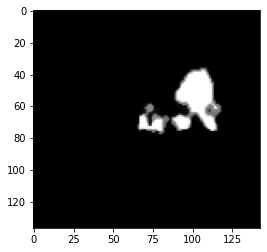

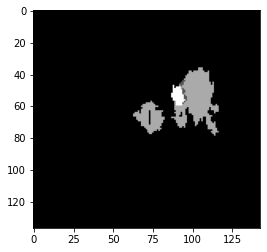

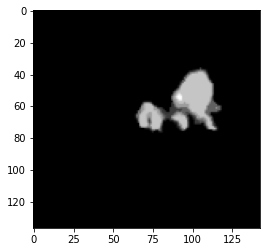

In [93]:
for i in range(55, 65, 2):
  plt.imshow(lbl[:,i,:], cmap='gray')
  plt.show()
  plt.imshow(lbl_p[:,i,:], cmap='gray')
  plt.show()

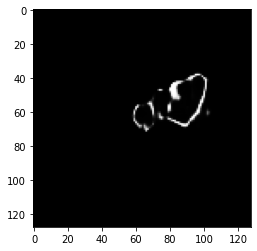

In [100]:
plt.imshow(img_p[0,0,:,55,:], cmap='gray')